##imports


In [55]:
# Core Python libraries
import os
import time
from IPython.display import clear_output, Image, display, HTML

# Scientific computing
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

# PyTorch core
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Sklearn utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Google Colab (if running in Colab)
from google.colab import drive

#MOUNT AND R/W DRIVE
drive.mount('/content/drive')
save_path = "/content/drive/MyDrive/Weights/best_model.pth"

#GPU or CPU  device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


#download data
if not os.path.exists("data.hdf5"):
    !gdown https://drive.google.com/uc?id=1LK65H6dtv34R_evtIHZGFPJlvCDFdWA7 -O data.hdf5


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda


##Normalisation function

In [56]:
def z_score_normaliser(x, dim=None):
    x = np.array(x)
    mean = np.mean(x, axis=dim, keepdims=True)
    std = np.std(x, axis=dim, keepdims=True)
    x = (x - mean) / (std + np.finfo(float).eps)  # Avoid divide-by-zero
    return x

def robust_z_score_normaliser0(x, dim=None):
    median = np.median(x, axis=dim, keepdims=True)
    mad = np.median(np.abs(x - median), axis=dim, keepdims=True)

    # Handle the case where mad is zero
    with np.errstate(divide='ignore'): # Suppress warnings when mad is zero.
        x = (x - median) / np.where(mad > 0, mad + np.finfo(float).eps, 1)

    return x

def robust_z_score_normaliser1(x, dim=None, min_mad=1e-25):  # Added min_mad parameter
    x = np.array(x)
    median = np.median(x, axis=dim, keepdims=True)
    mad = np.median(np.abs(x - median), axis=dim, keepdims=True)
    # Clip mad to avoid extremely small values
    mad = np.maximum(mad, min_mad)
    x = (x - median) / mad
    return x

def normaliser(x, dim=None, min_mad=1e-10, clip_max=1e10):
    x = np.array(x, dtype=np.float64)

    #Improved pre-processing
    inf_indices = np.isinf(x)  #Find infinite values
    x[inf_indices] = np.nan  #Treat infinities as NaNs for now, could also remove rows/columns

    nan_indices = np.isnan(x)
    x_copy = np.copy(x) #create a copy for imputation
    x_copy[nan_indices] = np.nanmedian(x_copy) #Impute NaNs with the median of the whole array. Adjust as needed!


    median = np.nanmedian(x_copy, axis=dim, keepdims=True)
    mad = np.nanmedian(np.abs(x_copy - median), axis=dim, keepdims=True)

    mad = np.maximum(mad, min_mad)
    mad = np.clip(mad, a_min=min_mad, a_max=clip_max)

    with np.errstate(invalid='ignore'):
        x = np.clip((x_copy - median) / mad, -clip_max, clip_max)

    return x

##standardisation and augmentation

In [57]:
# Load dataset NumPy Method
# log_H2O  log_CO2  log_CH4  log_CO  log_NH3

# open hdf5
ds = xr.open_dataset("data.hdf5")

rah='log_H2O'
rahh=rah[4:]

mol_header = ds['molecules'].values
chemical_abundances = ds['log_abundance'].values

print(mol_header)
print(chemical_abundances.shape)

included_molecules = ['H2O']
index = np.isin(mol_header, included_molecules)

labels_np = chemical_abundances[:, index]
labels_np.shape

spectra_np = ds['spectra'].values
spectra_np = np.nan_to_num(spectra_np, nan=0.0, posinf=np.nanmax(spectra_np), neginf=np.nanmin(spectra_np)) #better nan handling
spectra_np = normaliser(spectra_np, dim=1)  # Normalize each sample

#Add slight noise for augmentation
noise_strength = 0.01
augmented_spectra = spectra_np + np.random.normal(0, noise_strength, spectra_np.shape)
augmented_labels = labels_np.copy()

#augmented_spectra1 = spectra_np + np.random.normal(0, noise_strength, spectra_np.shape)
#augmented_labels1 = augmented_labels.copy()

# Combine original and augmented
spectra_np = np.concatenate([spectra_np, augmented_spectra], axis=0)
#spectra_np = np.concatenate([spectra_np, augmented_spectra1], axis=0)
labels_np = np.concatenate([labels_np, augmented_labels], axis=0)
#labels_np = np.concatenate([labels_np, augmented_labels1], axis=0)

print(spectra_np.shape)
print(labels_np.shape)

train_dataset = TensorDataset(torch.Tensor(spectra_np), torch.Tensor(labels_np))
print(train_dataset)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


ds



['PH3' 'P2H2_cis' 'P2H2_trans' 'O2' 'NH3' 'N2' 'H2O' 'CO2' 'CO' 'CH4']
(30000, 10)
(60000, 52)
(60000, 1)


<xarray.Dataset> Size: 18MB
Dimensions:             (samples: 30000, molecules: 10, wavelength: 52)
Coordinates:
  * samples             (samples) int64 240kB 0 1 2 3 ... 29997 29998 29999
  * molecules           (molecules) <U10 400B 'PH3' 'P2H2_cis' ... 'CO' 'CH4'
  * wavelength          (wavelength) float64 416B 0.55 0.7 0.95 ... 6.814 7.276
Data variables:
    log_abundance       (samples, molecules) float64 2MB -7.855 ... -7.177
    star_temperature    (samples) int64 240kB ...
    star_radius         (samples) float64 240kB ...
    planet_mass         (samples) float64 240kB ...
    planet_radius       (samples) float64 240kB ...
    planet_temperature  (samples) float64 240kB ...
    planet_distance     (samples) float64 240kB ...
    stellar_class       (samples) <U1 120kB ...
    planet_class        (samples) <U15 2MB ...
    spectra             (samples, wavelength) float64 12MB 0.01328 ... 0.0

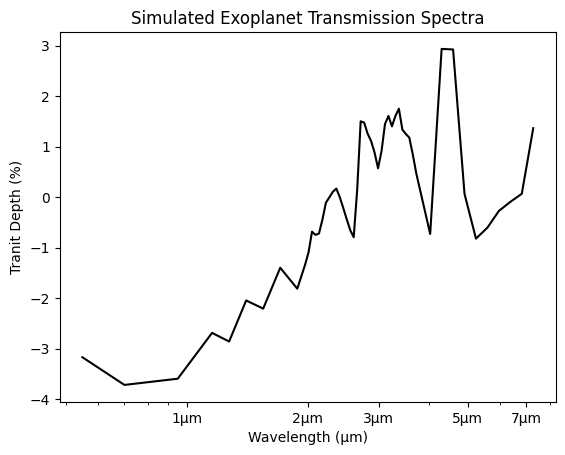

In [58]:
plt.plot(ds['wavelength'], spectra_np[0], color='black') # Plot the first spectrum, the 0 here means the first, so we can change that to 1 to plot the second, or 2 for the 3rd etc

def plot_extras(): # Define a little function so that we don't have to repeat this code to mkae our plots look nicer
    plt.xscale('log')
    plt.xticks([1, 2, 3, 5, 7], ['1µm', '2µm', '3µm', '5µm', '7µm'])
    plt.xlabel('Wavelength (µm)')
    plt.ylabel('Tranit Depth (%)')
    plt.title('Simulated Exoplanet Transmission Spectra')
plot_extras() # Call the function we just defined



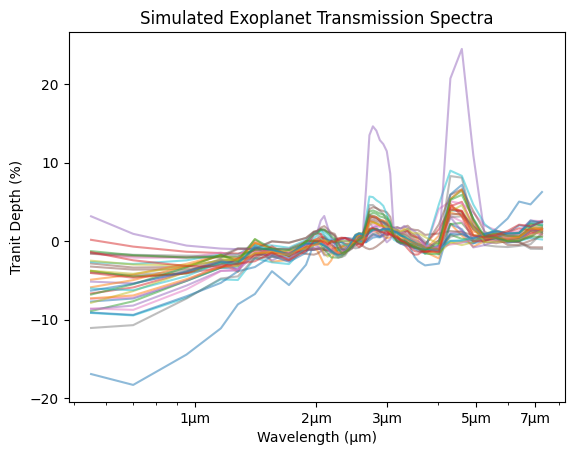

In [59]:
for i in range(1, 35): # Loop through the first 35 spectra
    plt.plot(ds['wavelength'], spectra_np[i], alpha=0.5) # Plot the spectra with a different colour, and a little transparency, this is what alpha=0.5 does. alpha=1 is fully opaque, and alpha=0 is fully transparent
    plot_extras()



## 📝 Test and Train Data!

While we could then train our model on all the data, because we are looking to validate the performance of the models, we hold back some of the data that the model has not seen before so that we can evaluate its performance! We will use 20\% of the data for testing, and train on the rest

In [60]:
# split train into train and test - we will use the test data to evaluate the model

tts = [0.8, 0.2] # 80% train, 20% test
seed = 42 # random seed for reproducibility
train_spectra, test_spectra, train_labels, test_labels = train_test_split(
    spectra_np, # here we input the regular spectra, but we should probably use the normalised spectra
    labels_np,
    test_size=tts[1],
    random_state=seed)

# print shapes in table
print(f"""
train_spectra: {train_spectra.shape}
train_labels: {train_labels.shape}

test_spectra: {test_spectra.shape}
test_labels: {test_labels.shape}
""")


train_spectra: (48000, 52)
train_labels: (48000, 1)

test_spectra: (12000, 52)
test_labels: (12000, 1)



---

## 🤖 Model:

Define your best model from previous sessions here! This is just an example

In [61]:
class ImprovedDeeperModel(nn.Module):
    def __init__(self):
        super(ImprovedDeeperModel, self).__init__()
        self.shortcut_proj = nn.Linear(1024, 512)

        self.fc1 = nn.Linear(52, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.dropout1 = nn.Dropout(0.05)

        self.fc2 = nn.Linear(1024, 768)
        self.bn2 = nn.BatchNorm1d(768)
        self.dropout2 = nn.Dropout(0.05)

        self.fc3 = nn.Linear(768, 512)
        self.bn3 = nn.BatchNorm1d(512)
        self.dropout3 = nn.Dropout(0.1)  # <- middle dropout a bit higher

        self.fc4 = nn.Linear(512, 384)
        self.bn4 = nn.BatchNorm1d(384)
        self.dropout4 = nn.Dropout(0.1)

        self.fc5 = nn.Linear(384, 256)
        self.bn5 = nn.BatchNorm1d(256)
        self.dropout5 = nn.Dropout(0.1)

        self.fc6 = nn.Linear(256, 128)
        self.bn6 = nn.BatchNorm1d(128)
        self.dropout6 = nn.Dropout(0.05)  # -> slightly lower again

        self.fc7 = nn.Linear(128, 64)
        self.bn7 = nn.BatchNorm1d(64)
        self.dropout7 = nn.Dropout(0.05)

        self.fc8 = nn.Linear(64, 32)
        self.bn8 = nn.BatchNorm1d(32)
        self.dropout8 = nn.Dropout(0.05)

        self.fc9 = nn.Linear(32, 1)  # Output

        self._initialize_weights()

    def forward(self, x):
        # Forward pass with optional tiny residual skip after first 3 layers
        x1 = F.silu(self.bn1(self.fc1(x)))
        x1 = self.dropout1(x1)

        x2 = F.silu(self.bn2(self.fc2(x1)))
        x2 = self.dropout2(x2)

        x3 = F.silu(self.bn3(self.fc3(x2)))
        x3 = self.dropout3(x3)

        shortcut = self.shortcut_proj(x1)  # project x1
        x3 = x3 + shortcut * 0.1


        x4 = F.silu(self.bn4(self.fc4(x3)))
        x4 = self.dropout4(x4)

        x5 = F.silu(self.bn5(self.fc5(x4)))
        x5 = self.dropout5(x5)

        x6 = F.silu(self.bn6(self.fc6(x5)))
        x6 = self.dropout6(x6)

        x7 = F.silu(self.bn7(self.fc7(x6)))
        x7 = self.dropout7(x7)

        x8 = F.silu(self.bn8(self.fc8(x7)))
        x8 = self.dropout8(x8)

        out = self.fc9(x8)

        return out

    def _initialize_weights(self):
        for layer in [
            self.fc1, self.fc2, self.fc3, self.fc4,
            self.fc5, self.fc6, self.fc7, self.fc8, self.fc9
        ]:
            init.kaiming_normal_(layer.weight, nonlinearity='relu', mode='fan_out')
            init.constant_(layer.bias, 0)


##.

In [62]:
model = ImprovedDeeperModel()
lr = 0.1
batch_size = 64

# create a loss function
criterion = nn.MSELoss().to(device)


# use GPU if available for faster training times
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('Using GPU')
elif torch.mps.is_available():
    device = torch.device("mps")
    print('Using MPS')
else:
    device = torch.device("cpu")
    print('Using CPU')

model.to(device)
test_spectra = torch.Tensor(test_spectra).to(device)
test_labels = torch.Tensor(test_labels).to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)
train_dataset = TensorDataset(torch.Tensor(train_spectra).to(device), torch.Tensor(train_labels).to(device))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

Using GPU


##Train

In [63]:
batch_losses = []
epoch_train_losses = []
epoch_test_losses = []

# train the model
model.train()
for epoch in range(50): # Keep the batch size low so we can train this quickly for today...
    for i, data in enumerate(train_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_losses.append(loss.item())

    with torch.no_grad():
        test_outputs = model(torch.Tensor(test_spectra))
        test_loss = criterion(test_outputs, test_labels)

    epoch_test_losses.append(test_loss.item())
    epoch_train_losses.append(np.mean(batch_losses))
    batch_losses = []

    if epoch % 1 == 0:
        print(f'epoch {epoch}, train loss {epoch_train_losses[-1]}, test loss {test_loss.item()}')

epoch 0, train loss 2.2011828640302022, test loss 4.409614562988281


KeyboardInterrupt: 

---

## ✅ Validation:

We will use our test data that the model has never seen in order to test how accurate the model is with it's predictions. Then we can create some plots the same as last time...

In [ ]:
# generate the test set predictions
with torch.no_grad():
    test_outputs = model(test_spectra)

# plot the final predictions
for i in range(labels.shape[1]):
    plt.figure(figsize=(5, 5))
    plt.plot(test_labels.cpu().numpy()[:, i], test_outputs.cpu().numpy()[:, i],'kx', label=mol_header[i], alpha=0.5)

    plt.plot([test_labels.cpu().numpy()[:, i].min(),
            test_labels.cpu().numpy()[:, i].max()],
            [test_labels.cpu().numpy()[:, i].min(),
            test_labels.cpu().numpy()[:, i].max()], 'r--', lw=2)

    plt.xlabel(f'True Abundance of {mol_header[index][i]}')
    plt.ylabel(f'Predicted Abundance of {mol_header[index][i]}')


Does this look good? Is the model performing as expected? If not, consider, is the normalisation working as anticipated? Are there different ways that you could normalise the data?

We can print a quick overview of what we have achieved here

In [ ]:
print(f'best test loss: {min(epoch_test_losses)}')
print('---')
print(f'model architecture: {model}')
print(f'learning rate: {lr}')
print(f'batch size: {batch_size}')